In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
idx = pd.IndexSlice

In [2]:
laps = pd.read_pickle('data/96/merge_laps')

In [3]:
pits = pd.read_pickle('data/96/merge_pits')

Convert columns to numeric, tyre and fuel to % of max capacity

In [4]:
pits['Pit'] = pd.to_numeric(pits['Pit'].str.split().str[-1].str[:-1])
pits['Tyres condition'] = pd.to_numeric(pits['Tyres condition'].str[:-1])/100
pits['Fuel left'] = pd.to_numeric(pits['Fuel left'].str[:-1])/100
pits['Pit time'] = pd.to_numeric(pits['Pit time'].str[:-1])
pits['Refilled to'] = (pd.to_numeric(pits['Refilled to'].str.split().str[0], 'coerce')/180).fillna(pits['Fuel left'])
pits

Pit                          Pitstop reason  Tyres condition  Fuel left  \
10 0    3  Tyres change due to the weather change             0.86       0.49   
   1   22                   No more fuel was left             0.34       0.02   
   2   35                   No more fuel was left             0.54       0.00   
   3   48                   No more fuel was left             0.53       0.00   
11 0    3  Tyres change due to the weather change             0.84       0.37   
   1   28                   No more fuel was left             0.41       0.01   
   2   54                   No more fuel was left             0.38       0.00   

      Refilled to  Pit time  
10 0     0.490000    34.035  
   1     0.333333    21.711  
   2     0.333333    26.025  
   3     0.333333    25.337  
11 0     0.416667    36.748  
   1     0.416667    25.267  
   2     0.416667    27.122

Create 'Delta' column with laps before each pit stop

In [5]:
pits['Delta'] = pits['Pit'].diff()
pits.loc[idx[:, 0], 'Delta'] = pits.loc[idx[:, 0], 'Pit']
pits

Pit                          Pitstop reason  Tyres condition  Fuel left  \
10 0    3  Tyres change due to the weather change             0.86       0.49   
   1   22                   No more fuel was left             0.34       0.02   
   2   35                   No more fuel was left             0.54       0.00   
   3   48                   No more fuel was left             0.53       0.00   
11 0    3  Tyres change due to the weather change             0.84       0.37   
   1   28                   No more fuel was left             0.41       0.01   
   2   54                   No more fuel was left             0.38       0.00   

      Refilled to  Pit time  Delta  
10 0     0.490000    34.035    3.0  
   1     0.333333    21.711   19.0  
   2     0.333333    26.025   13.0  
   3     0.333333    25.337   13.0  
11 0     0.416667    36.748    3.0  
   1     0.416667    25.267   25.0  
   2     0.416667    27.122   26.0

Fuel and tyre used columns so we can build a linear model with 0 intercept

In [6]:
pits['Fuel used'] = pits['Refilled to'].shift(1) - pits['Fuel left']
pits.loc[idx[:, 0], 'Fuel used'] = pd.NA
pits['Tyres used'] = 1 - pits['Tyres condition']
pits

Pit                          Pitstop reason  Tyres condition  Fuel left  \
10 0    3  Tyres change due to the weather change             0.86       0.49   
   1   22                   No more fuel was left             0.34       0.02   
   2   35                   No more fuel was left             0.54       0.00   
   3   48                   No more fuel was left             0.53       0.00   
11 0    3  Tyres change due to the weather change             0.84       0.37   
   1   28                   No more fuel was left             0.41       0.01   
   2   54                   No more fuel was left             0.38       0.00   

      Refilled to  Pit time  Delta  Fuel used  Tyres used  
10 0     0.490000    34.035    3.0        NaN        0.14  
   1     0.333333    21.711   19.0   0.470000        0.66  
   2     0.333333    26.025   13.0   0.333333        0.46  
   3     0.333333    25.337   13.0   0.333333        0.47  
11 0     0.416667    36.748    3.0        NaN        0.16  
   1     0.416667    25.267   25.0   0.406667        0.59  
   2     0.416667    27.122   26.0   0.416667        0.62

Removed tyre per pit stop

In [7]:
pits['Tyres'] = laps.loc[zip(pits['Pit'].index.get_level_values(0), pits['Pit'] - 1), 'Tyres'].values
pits

Pit                          Pitstop reason  Tyres condition  Fuel left  \
10 0    3  Tyres change due to the weather change             0.86       0.49   
   1   22                   No more fuel was left             0.34       0.02   
   2   35                   No more fuel was left             0.54       0.00   
   3   48                   No more fuel was left             0.53       0.00   
11 0    3  Tyres change due to the weather change             0.84       0.37   
   1   28                   No more fuel was left             0.41       0.01   
   2   54                   No more fuel was left             0.38       0.00   

      Refilled to  Pit time  Delta  Fuel used  Tyres used       Tyres  
10 0     0.490000    34.035    3.0        NaN        0.14        Rain  
   1     0.333333    21.711   19.0   0.470000        0.66      Medium  
   2     0.333333    26.025   13.0   0.333333        0.46      Medium  
   3     0.333333    25.337   13.0   0.333333        0.47      Medium  
11 0     0.416667    36.748    3.0        NaN        0.16  Extra Soft  
   1     0.416667    25.267   25.0   0.406667        0.59        Rain  
   2     0.416667    27.122   26.0   0.416667        0.62        Rain

Linearly model tyre and fuel % use per lap, need to omit first laps since they have NaNs (will fix once starting fuel is scrapped).

In [8]:
colors = {'Extra Soft': 'pink', 'Soft': 'red', 'Medium': 'yellow', 'Hard': 'grey', 'Rain': 'blue'}
tyres = colors.keys()

In [9]:
mtyres = {}
for tyre, data in pits.groupby('Tyres'):
    delta = data['Delta'].to_numpy()[:, np.newaxis]
    mtyres[tyre] = np.linalg.lstsq(delta, data['Tyres used'], rcond=None)[0][0]

delta = pits['Delta'].to_numpy()[:, np.newaxis]
mf = np.linalg.lstsq(delta[pits['Fuel used'].notna()], pits['Fuel used'][pits['Fuel used'].notna()], rcond=None)[0][0]

print([f'{tyre}%/lap: {round(mtyres[tyre], 3)}' for tyre in mtyres])
print('Fuel%/lap:', round(mf, 3))

['Extra Soft%/lap: 0.053', 'Medium%/lap: 0.035', 'Rain%/lap: 0.024']
Fuel%/lap: 0.019


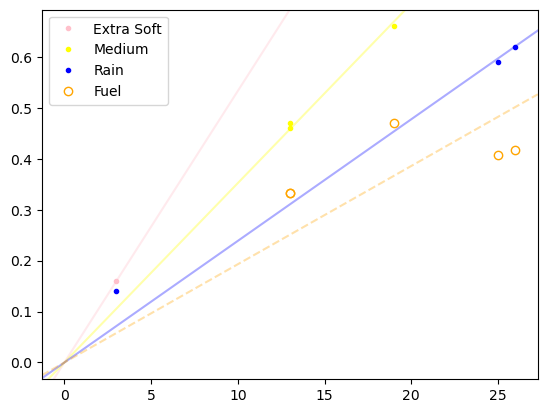

In [10]:
for tyre, data in pits.groupby('Tyres'):
    plt.plot(data['Delta'], data['Tyres used'], '.', label = tyre, c = colors[tyre])
    plt.axline((0, 0), slope = mtyres[tyre], c = colors[tyre], alpha = 0.33)

plt.plot(pits['Delta'], pits['Fuel used'], 'o', label = 'Fuel', c = 'orange', fillstyle = 'none')
plt.axline((0, 0), slope = mf, c = 'orange', alpha = 0.33, linestyle = '--')

plt.legend()